<div id="container" style="position:relative;">
<div style="float:left"><h1>Data Preparation and Exploration: Issued Building Permits </h1></div>
<div style="position:relative; float:right">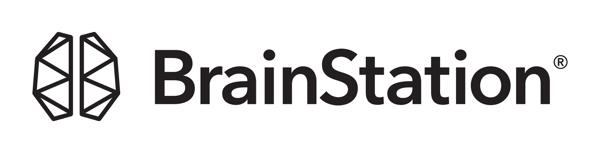
</div>
</div>


In [167]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

## Basic Data Wrangling

### Dataset
Throughout this notebook I will use the `issued-building-permits.csv` dataset. 

Building permits are required for new buildings, additions or alterations to existing buildings, and for demolitions or salvage and abatement work.

You can download the dataset from [here](https://opendata.vancouver.ca/explore/dataset/issued-building-permits/export/)

### Question of interest

> TODO

In [168]:
df = pd.read_csv('issued-building-permits.csv', delimiter=";")
df.head()

,PermitNumber,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,TypeOfWork,Address,ProjectDescription,PermitCategory,Applicant,ApplicantAddress,PropertyUse,SpecificUseCategory,BuildingContractor,BuildingContractorAddress,IssueYear,GeoLocalArea,Geom,YearMonth,geo_point_2d
0,DB-2023-00041,2023-01-05,2023-04-28,113,198847.5,New Building,"7475 DUMFRIES STREET, Vancouver, BC",Low Density Housing - New Building - To constr...,New Build - Standalone Laneway,Shalindro Dosanjh,"1185 49 th Ave West\r\nVancouver,, BC V6M 2P9",Dwelling Uses,Laneway House,Amcata Homes Developments Ltd,"1185 W 49TH AV \r\nVancouver, BC V6M 2P9",2023,Victoria-Fraserview,"{""coordinates"": [-123.0755831, 49.2165995], ""t...",2023-04,"49.2165995, -123.0755831"
1,BP-2023-00049,2023-01-06,2023-03-29,82,0.0,Salvage and Abatement,"1137 E 29TH AVENUE, Vancouver, BC V5V 2S7",Low Density Housing - Salvage and Abatement - ...,NaN,John Keen DBA: Farpoint Architectural Inc.,"1662 West 75th Ave.\r\nVancouver, BC V6P 6G2",Dwelling Uses,Single Detached House,Vancouver Excavating and Contracting Ltd,"25 Howard Ave \r\nBurnaby, BC V5B 3P3",2023,Kensington-Cedar Cottage,"{""coordinates"": [-123.081827, 49.244843], ""typ...",2023-03,"49.244843, -123.081827"
2,DB-2023-00050,2023-01-06,2023-09-12,249,1068777.5,New Building,"85 W 48TH AVENUE, Vancouver, BC V5Y 2Y5",Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Embark Homes DBA: Embark Homes LTD,"501-4289 Hastings Street\r\nBurnaby, BC V5C0K9",Dwelling Uses,Single Detached House w/Sec Suite,Embark Homes LTD,NaN,2023,Oakridge,"{""coordinates"": [-123.1079161, 49.2270346], ""t...",2023-09,"49.2270346, -123.1079161"
3,DB-2023-00064,2023-01-06,2023-10-04,271,155030.0,New Building,"95 E 59TH AVENUE #3, Vancouver, BC",Low Density Housing - New Building - To constr...,New Build - Standalone Laneway,Wayne Ng DBA: Skymark Engineering Ltd,"3383 Queens Ave\r\nVancouver, BC V5R 4T9",Dwelling Uses,Laneway House,Semlin Construction Ltd,"949 Esmond Ave \r\nBurnaby, BC V5C 6A6",2023,Sunset,"{""coordinates"": [-123.1041746, 49.2170343], ""t...",2023-10,"49.2170343, -123.1041746"
4,DB-2023-00065,2023-01-06,2023-03-31,84,692250.0,New Building,NaN,Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Jordan Talhan DBA: 0686632 BC LTD,"12945 56A Avenue \r\nSurrey, BC V3X2Z1",Dwelling Uses,Duplex w/Secondary Suite,Rungur Sherhomes Group Ltd,NaN,2023,NaN,NaN,2023-03,NaN


In [169]:
df.tail()

,PermitNumber,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,TypeOfWork,Address,ProjectDescription,PermitCategory,Applicant,ApplicantAddress,PropertyUse,SpecificUseCategory,BuildingContractor,BuildingContractorAddress,IssueYear,GeoLocalArea,Geom,YearMonth,geo_point_2d
39554,BP-2023-02462,2023-07-13,2024-01-30,201,15000.0,Demolition / Deconstruction,"3505 FLEMING STREET, Vancouver, BC V5N 3V7",Low Density Housing - Demolition / Deconstruct...,NaN,Scott Kennedy DBA: Cornerstone Architecture,"#307 - 611 Alexander Street\r\nVANCOUVER, BC ...",Dwelling Uses,Single Detached House,Noble Construction Management Corp,"4308 Dawson St \r\nUnit 200\r\nBurnaby, BC V...",2024,Kensington-Cedar Cottage,"{""coordinates"": [-123.0717985, 49.2533898], ""t...",2024-01,"49.2533898, -123.0717985"
39555,DB-2023-02482,2023-07-13,2023-10-20,99,1200000.0,New Building,"3569 W 30TH AVENUE, Vancouver, BC V6S 1W6",Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Danny Lung & Sharon Chen DBA: Lung Designs Gro...,LUNG DESIGNS GROUP LTD\r\nUNIT 268-2633 VIKING...,Dwelling Uses,"Secondary Suite,Duplex w/Secondary Suite",RBC Holdings Ltd,"4112 HEATHER ST \r\nVancouver, BC V5Z 0B5",2023,Dunbar-Southlands,"{""coordinates"": [-123.1839825, 49.2454866], ""t...",2023-10,"49.2454866, -123.1839825"
39556,BP-2023-02488,2023-07-13,2024-01-09,180,35000.0,Addition / Alteration,"1314 SW MARINE DRIVE, Vancouver, BC V6P 5Z6",Field Review - Addition / Alteration - Related...,Renovation - Commercial/ Mixed Use - Lower Com...,Kanaris Lazos,"1310 Sinclair Street\r\nWest Vancouver, BC V7...",Retail Uses,Retail Store,NaN,NaN,2024,Marpole,"{""coordinates"": [-123.1359163, 49.2030462], ""t...",2024-01,"49.2030462, -123.1359163"
39557,DB-2023-02489,2023-07-13,2023-09-27,76,676000.0,New Building,"2616 NAPIER STREET, Vancouver, BC V5K 2W6",Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Kuldip Brar,"1244 grand boulevard east\r\nnorth vancouver, ...",Dwelling Uses,Duplex,Brar Empire Homes Ltd,"1244 Grand Blvd \r\nNorth Vancouver, BC V7L 3X4",2023,Hastings-Sunrise,"{""coordinates"": [-123.0515287, 49.2747355], ""t...",2023-09,"49.2747355, -123.0515287"
39558,BP-2021-01316,2021-04-06,2021-08-16,132,129000.0,Addition / Alteration,"2920 VIRTUAL WAY, Vancouver, BC V5M 0C4",Field Review - Addition / Alteration - #30 \r\...,Renovation - Commercial/ Mixed Use - Lower Com...,Jan Van de fliert DBA: BLUE ROCK Construction ...,"43 auburn meadows crescent SE\r\nCalgary, AB ...",Retail Uses,Retail Store,Blue Rock Construction Management Ltd,"43 Auburn Meadows Cres SE \r\nCalgary, AB T3...",2021,Renfrew-Collingwood,"{""coordinates"": [-123.0434214, 49.2610707], ""t...",2021-08,"49.2610707, -123.0434214"


In [170]:
df.sample(15)

,PermitNumber,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,TypeOfWork,Address,ProjectDescription,PermitCategory,Applicant,ApplicantAddress,PropertyUse,SpecificUseCategory,BuildingContractor,BuildingContractorAddress,IssueYear,GeoLocalArea,Geom,YearMonth,geo_point_2d
32630,DB-2017-02041,2017-04-19,2017-12-13,238,88000.00,Addition / Alteration,"1455 E GEORGIA STREET, Vancouver, BC V5L 2A9",High Density Housing / Commercial - Addition /...,NaN,Ron Hart DBA: Ron Hart Architect,"206 - 151 W 1ST AV\r\nVANCOUVER, BC V5Y 0A5",Manufacturing Uses,Metal Products Mfg - Class A,NaN,NaN,2017,Grandview-Woodland,"{""coordinates"": [-123.0746886, 49.2787885], ""t...",2017-12,"49.2787885, -123.0746886"
31787,DB-2021-00488,2021-02-10,2021-05-27,106,70000.00,Addition / Alteration,"107 N KASLO STREET, Vancouver, BC V5K 3M9",Enquiry Centre - Addition / Alteration - Exter...,Renovation - Residential - Lower Complexity,Ian Ho,"#6 - 719 E. 31st Avenue\r\nVancouver , BC V5V...",Dwelling Uses,Single Detached House w/Sec Suite,NaN,NaN,2021,Hastings-Sunrise,"{""coordinates"": [-123.0470984, 49.2858288], ""t...",2021-05,"49.2858288, -123.0470984"
1921,BP-2019-01227,2019-03-21,2021-07-28,860,85000000.00,New Building,"32 W HASTINGS STREET, Vancouver, BC V6B 1G6",Certified Professional Program - New Building ...,NaN,Michael Van Blokland DBA: LMDG Building Code C...,"4th Floor - 780 Beatty Street\r\nVancouver, BC...","Dwelling Uses,Office Uses,Parking Uses,Retail ...","Health Care Office,Multiple Dwelling,Parking G...",Axiom Builders Inc,"838 W HASTINGS ST \r\nUnit 1100\r\nVancouver,...",2021,Downtown,"{""coordinates"": [-123.1057289, 49.2816717], ""t...",2021-07,"49.2816717, -123.1057289"
7997,BP-2021-01908,2021-04-29,2021-11-30,215,4000.00,Addition / Alteration,"6789 SELKIRK STREET, Vancouver, BC V6P 4G9",Field Review - Addition / Alteration - Interio...,Renovation - Residential - Lower Complexity,Vincent Wan DBA: D.V. Design Ltd.,"4038 Toronto Street\r\nPort Coquitlam, BC V3B6X8",Dwelling Uses,Single Detached House,NaN,NaN,2021,Oakridge,"{""coordinates"": [-123.1337899, 49.2241674], ""t...",2021-11,"49.2241674, -123.1337899"
11924,BP-2020-01726,2020-06-04,2020-08-18,75,0.00,Salvage and Abatement,"2369 E 10TH AVENUE, Vancouver, BC V5N 1Y4",Enquiry Centre - Salvage and Abatement - Inter...,NaN,Troy Abromaitis DBA: Bucci Garden Homes Ltd,1669 West 3rd Avenue\r\nSuite 202\r\nVancouver...,Dwelling Uses,Single Detached House,Clearview Demolition Ltd,NaN,2020,Kensington-Cedar Cottage,"{""coordinates"": [-123.0575378, 49.2614601], ""t...",2020-08,"49.2614601, -123.0575378"
16020,BP-2023-02624,2023-07-25,2023-08-15,21,180000.00,Addition / Alteration,"1001 W BROADWAY, Vancouver, BC V6H 4B1",Field Review - Addition / Alteration - #300 - ...,Renovation - Commercial/ Mixed Use - Lower Com...,Alison Lau DBA: Counterpoint Projects Inc,"#400 - 224 W 8th Avenue\r\nVancouver, BC V5Y 1N5",Office Uses,General Office,Counterpoint Interiors Inc,"224 W 8TH AV \r\nUnit 400\r\nVancouver, BC V...",2023,Fairview,"{""coordinates"": [-123.1271155, 49.2637133], ""t...",2023-08,"49.2637133, -123.1271155"
21258,DB-2017-04436,2017-08-25,2017-11-22,89,119236.95,Addition / Alteration,"2912 W 14TH AVENUE, Vancouver, BC V6K 2X6",Field Review - Addition / Alteration - Interio...,Renovation - Residential - Lower Complexity,DOS Design Group,"81 Golden Drive\r\nUnit 110A\r\nCoquitlam, BC ...",Dwelling Uses,Single Detached House w/Sec Suite,NaN,NaN,2017,Kitsilano,"{""coordinates"": [-123.170628, 49.2593416], ""ty...",2017-11,"49.2593416, -123.170628"
8780,BP-2021-06633,2021-12-14,2022-01-28,45,30000.00,Addition / Alteration,"1005 JERVIS STREET, Vancouver, BC V6E 3T1",Field Review - Addition / Alteration - #803 - ...,Renovation - Residential - Lower Complexity,McCuaig and Associates Engineering Ltd.,"200 - 3999 Henning Drive\r\nBurnaby, BC V5C 6P9",Dwelling Uses,Multiple Dwelling,Solid General Contractors Inc,"4163 McConnell Dr \r\nBurnaby, BC V5A 3J7",2022,West End,"{""coordinat

In [171]:
df.shape

(39559, 20)

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39559 entries, 0 to 39558
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PermitNumber               39559 non-null  object 
 1   PermitNumberCreatedDate    39559 non-null  object 
 2   IssueDate                  39559 non-null  object 
 3   PermitElapsedDays          39559 non-null  int64  
 4   ProjectValue               39559 non-null  float64
 5   TypeOfWork                 39559 non-null  object 
 6   Address                    39402 non-null  object 
 7   ProjectDescription         39559 non-null  object 
 8   PermitCategory             22551 non-null  object 
 9   Applicant                  39559 non-null  object 
 10  ApplicantAddress           39452 non-null  object 
 11  PropertyUse                39554 non-null  object 
 12  SpecificUseCategory        39552 non-null  object 
 13  BuildingContractor         24562 non-null  obj

### Step 1: Formatting & Validity


In [173]:
df['PermitNumberCreatedDate'].head(5)

0    2023-01-05
1    2023-01-06
2    2023-01-06
3    2023-01-06
4    2023-01-06
Name: PermitNumberCreatedDate, dtype: object

In [174]:
df['PermitNumberCreatedDate'] = pd.to_datetime(df['PermitNumberCreatedDate'])
df['IssueDate'] = pd.to_datetime(df['IssueDate'])


In [175]:
# Confirm that the type has been changed for Date column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39559 entries, 0 to 39558
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   PermitNumber               39559 non-null  object        
 1   PermitNumberCreatedDate    39559 non-null  datetime64[ns]
 2   IssueDate                  39559 non-null  datetime64[ns]
 3   PermitElapsedDays          39559 non-null  int64         
 4   ProjectValue               39559 non-null  float64       
 5   TypeOfWork                 39559 non-null  object        
 6   Address                    39402 non-null  object        
 7   ProjectDescription         39559 non-null  object        
 8   PermitCategory             22551 non-null  object        
 9   Applicant                  39559 non-null  object        
 10  ApplicantAddress           39452 non-null  object        
 11  PropertyUse                39554 non-null  object        
 12  Spec

In [176]:
df.head()

,PermitNumber,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,TypeOfWork,Address,ProjectDescription,PermitCategory,Applicant,ApplicantAddress,PropertyUse,SpecificUseCategory,BuildingContractor,BuildingContractorAddress,IssueYear,GeoLocalArea,Geom,YearMonth,geo_point_2d
0,DB-2023-00041,2023-01-05,2023-04-28,113,198847.5,New Building,"7475 DUMFRIES STREET, Vancouver, BC",Low Density Housing - New Building - To constr...,New Build - Standalone Laneway,Shalindro Dosanjh,"1185 49 th Ave West\r\nVancouver,, BC V6M 2P9",Dwelling Uses,Laneway House,Amcata Homes Developments Ltd,"1185 W 49TH AV \r\nVancouver, BC V6M 2P9",2023,Victoria-Fraserview,"{""coordinates"": [-123.0755831, 49.2165995], ""t...",2023-04,"49.2165995, -123.0755831"
1,BP-2023-00049,2023-01-06,2023-03-29,82,0.0,Salvage and Abatement,"1137 E 29TH AVENUE, Vancouver, BC V5V 2S7",Low Density Housing - Salvage and Abatement - ...,NaN,John Keen DBA: Farpoint Architectural Inc.,"1662 West 75th Ave.\r\nVancouver, BC V6P 6G2",Dwelling Uses,Single Detached House,Vancouver Excavating and Contracting Ltd,"25 Howard Ave \r\nBurnaby, BC V5B 3P3",2023,Kensington-Cedar Cottage,"{""coordinates"": [-123.081827, 49.244843], ""typ...",2023-03,"49.244843, -123.081827"
2,DB-2023-00050,2023-01-06,2023-09-12,249,1068777.5,New Building,"85 W 48TH AVENUE, Vancouver, BC V5Y 2Y5",Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Embark Homes DBA: Embark Homes LTD,"501-4289 Hastings Street\r\nBurnaby, BC V5C0K9",Dwelling Uses,Single Detached House w/Sec Suite,Embark Homes LTD,NaN,2023,Oakridge,"{""coordinates"": [-123.1079161, 49.2270346], ""t...",2023-09,"49.2270346, -123.1079161"
3,DB-2023-00064,2023-01-06,2023-10-04,271,155030.0,New Building,"95 E 59TH AVENUE #3, Vancouver, BC",Low Density Housing - New Building - To constr...,New Build - Standalone Laneway,Wayne Ng DBA: Skymark Engineering Ltd,"3383 Queens Ave\r\nVancouver, BC V5R 4T9",Dwelling Uses,Laneway House,Semlin Construction Ltd,"949 Esmond Ave \r\nBurnaby, BC V5C 6A6",2023,Sunset,"{""coordinates"": [-123.1041746, 49.2170343], ""t...",2023-10,"49.2170343, -123.1041746"
4,DB-2023-00065,2023-01-06,2023-03-31,84,692250.0,New Building,NaN,Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Jordan Talhan DBA: 0686632 BC LTD,"12945 56A Avenue \r\nSurrey, BC V3X2Z1",Dwelling Uses,Duplex w/Secondary Suite,Rungur Sherhomes Group Ltd,NaN,2023,NaN,NaN,2023-03,NaN


In [177]:
df.describe()

,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,IssueYear
count,39559,39559,39559.000000,3.955900e+04,39559.000000
mean,2019-12-11 21:31:04.930862592,2020-04-26 19:08:14.602997760,136.900806,7.145714e+05,2019.835284
min,2013-07-25 00:00:00,2017-01-03 00:00:00,0.000000,0.000000e+00,2017.000000
25%,2018-02-16 00:00:00,2018-06-25 00:00:00,40.000000,1.050000e+04,2018.000000
50%,2019-10-16 00:00:00,2020-02-19 00:00:00,90.000000,4.800000e+04,2020.000000
75%,2021-10-04 00:00:00,2022-03-10 00:00:00,193.000000,2.250000e+05,2022.000000
max,2024-02-05 00:00:00,2024-02-07 00:00:00,2023.000000,1.468680e+09,2024.000000
std,NaN,NaN,140.046465,1.085674e+07,2.075687


### Step 2: Checking for duplicates and redundant information 


In [178]:

df.duplicated().sum()

0

In [179]:

df.T.duplicated()

PermitNumber                 False
PermitNumberCreatedDate      False
IssueDate                    False
PermitElapsedDays            False
ProjectValue                 False
TypeOfWork                   False
Address                      False
ProjectDescription           False
PermitCategory               False
Applicant                    False
ApplicantAddress             False
PropertyUse                  False
SpecificUseCategory          False
BuildingContractor           False
BuildingContractorAddress    False
IssueYear                    False
GeoLocalArea                 False
Geom                         False
YearMonth                    False
geo_point_2d                 False
dtype: bool

In [180]:
mosquito_df.info()

NameError: name 'mosquito_df' is not defined

### Step 3 - Missing Data TODO check how to fill in PermitCategory???



First, I look at the number of missing values in each column:

In [ ]:
df.isna().sum()

Let's look at the percentage of missing values instead:

In [ ]:
df.isna().mean()*100

In [ ]:
df["BuildingContractorAddress"].value_counts()


In [ ]:
df[df["PermitCategory"]== 'Renovation - Commercial/ Mixed Use - Lower Complexity']

In [ ]:
df[df["PermitCategory"].isnull()]

### Exploratory Data Analysis (EDA)

In [181]:
# Numerical columns
numerical_columns = ['PermitElapsedDays', 'ProjectValue']

# Categorical columns

categorical_columns = ['TypeOfWork', 'PermitCategory', 'PropertyUse', 'SpecificUseCategory', 'IssueYear', 'GeoLocalArea', 'YearMonth']
categorical_columns = ['TypeOfWork', 'PermitCategory', 'IssueYear', 'GeoLocalArea']

# TODO: YearMonth ? time series? 

In [182]:
df["PropertyUse"].value_counts().head(40)
# TODO join Dwelling Uses,Institutional Uses to  Dwelling uses may be ?

PropertyUse
Dwelling Uses                                          27805
Office Uses                                             4890
Retail Uses                                             1913
Service Uses                                            1570
Institutional Uses                                       781
Cultural/Recreational Uses                               644
Manufacturing Uses                                       292
Office Uses,Retail Uses                                  151
Wholesale Uses                                           142
Dwelling Uses,Retail Uses                                132
Transportation and Storage Uses                          128
Parking Uses                                             110
Retail Uses,Service Uses                                  91
Office Uses,Service Uses                                  78
Dwelling Uses,Parking Uses                                77
Utility and Communication Uses                            65
Dwelling Use

In [183]:
df["SpecificUseCategory"].value_counts().head(40)
# TODO join somethins?

SpecificUseCategory
Single Detached House                       10457
Single Detached House w/Sec Suite            5352
Multiple Dwelling                            5056
General Office                               4144
Laneway House                                3279
Duplex                                       1586
Retail Store                                 1508
Restaurant - Class 1                          722
Duplex w/Secondary Suite                      630
Dwelling Unit                                 472
Health Care Office                            427
Not Applicable                                366
Multiple Conversion Dwelling                  319
Hospital                                      195
Infill Single Detached House                  186
Beauty and Wellness Centre                    164
Financial Institution                         156
Park or Playground                            154
School - Elementary or Secondary              140
Barber Shop or Beauty Salon   

In [184]:
column = "PermitElapsedDays" 

In [185]:
df[column].describe()

count    39559.000000
mean       136.900806
std        140.046465
min          0.000000
25%         40.000000
50%         90.000000
75%        193.000000
max       2023.000000
Name: PermitElapsedDays, dtype: float64

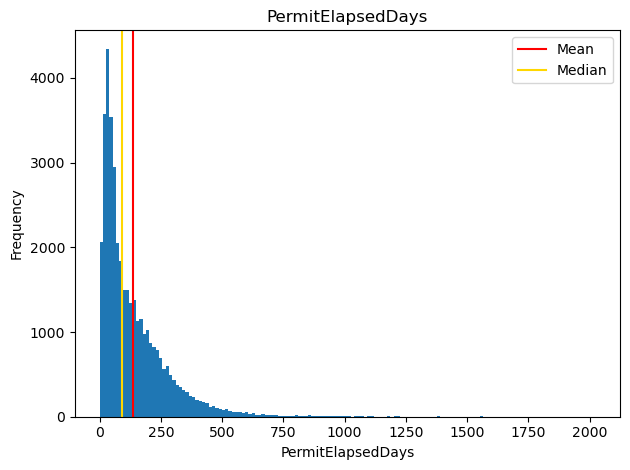

In [186]:

plt.hist(df[column], bins=150)
plt.title(column)
plt.xlabel(column)
plt.ylabel('Frequency')
plt.axvline(df[column].mean(), c='red', label='Mean')
plt.axvline(df[column].median(), c='gold', label='Median')
plt.legend()   
plt.tight_layout()

plt.show()


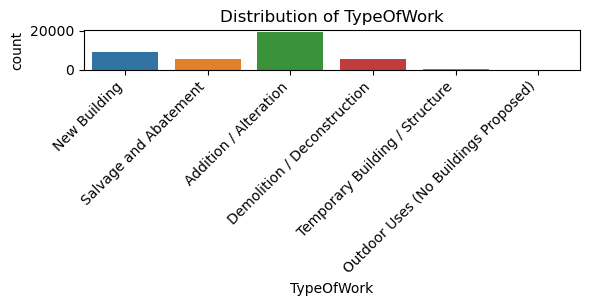

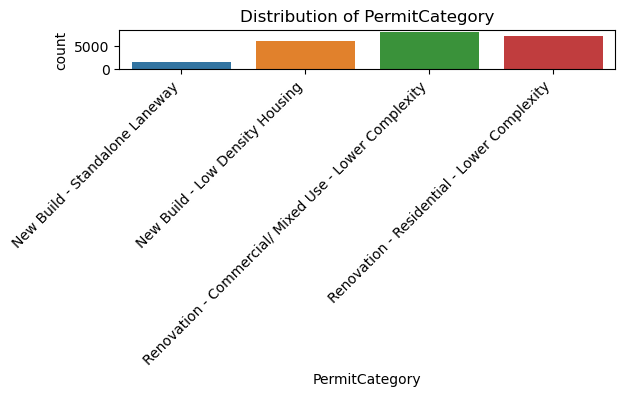

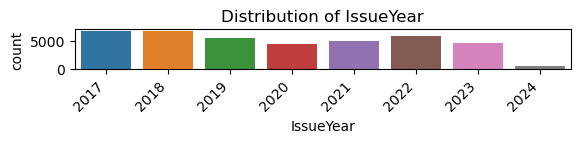

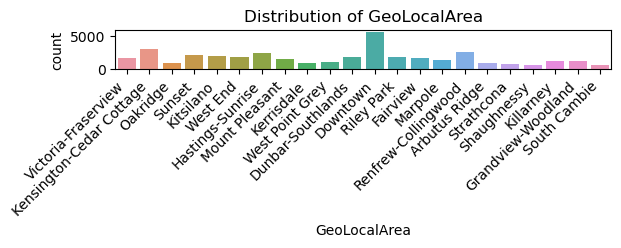

In [187]:
# Distribution of categorical columns

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(8, 1, i)
    sns.countplot(x=column, data=df)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45, ha='right')
    plt.show()



### Create dummy values

In [188]:
# Check the possible values
df['TypeOfWork'].value_counts()

TypeOfWork
Addition / Alteration                   19204
New Building                             9004
Salvage and Abatement                    5612
Demolition / Deconstruction              5296
Temporary Building / Structure            387
Outdoor Uses (No Buildings Proposed)       56
Name: count, dtype: int64

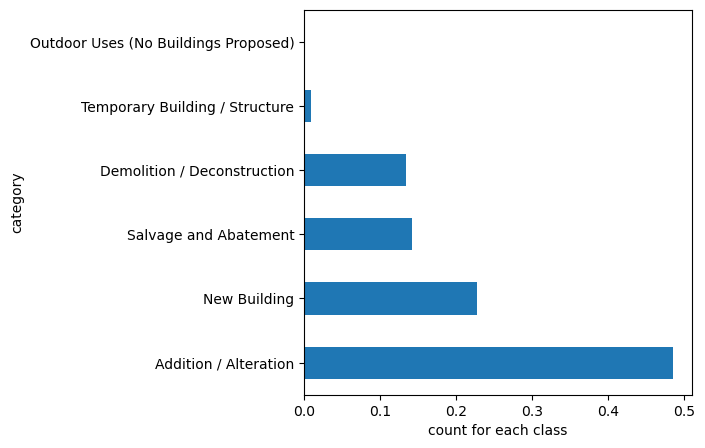

In [189]:
# Let's visualize the target distribution 

df['TypeOfWork'].value_counts(normalize=True).plot(kind='barh', figsize = (5,5))

plt.xlabel('count for each class')
plt.ylabel('category')
plt.show()

In [190]:
type_dummies = pd.get_dummies(df['TypeOfWork'], prefix='Type', dtype=np.int32)
df = pd.concat([df, type_dummies], axis=1)

type_dummies.var().sort_values()

Type_Outdoor Uses (No Buildings Proposed)    0.001414
Type_Temporary Building / Structure          0.009687
Type_Demolition / Deconstruction             0.115956
Type_Salvage and Abatement                   0.121742
Type_New Building                            0.175808
Type_Addition / Alteration                   0.249795
dtype: float64

In [191]:
df.drop(['Type_Outdoor Uses (No Buildings Proposed)'], axis = 1, inplace=True) 

In [192]:
df.columns

Index(['PermitNumber', 'PermitNumberCreatedDate', 'IssueDate',
       'PermitElapsedDays', 'ProjectValue', 'TypeOfWork', 'Address',
       'ProjectDescription', 'PermitCategory', 'Applicant', 'ApplicantAddress',
       'PropertyUse', 'SpecificUseCategory', 'BuildingContractor',
       'BuildingContractorAddress', 'IssueYear', 'GeoLocalArea', 'Geom',
       'YearMonth', 'geo_point_2d', 'Type_Addition / Alteration',
       'Type_Demolition / Deconstruction', 'Type_New Building',
       'Type_Salvage and Abatement', 'Type_Temporary Building / Structure'],
      dtype='object')

### Exploring correlations

In [193]:

columns_to_keep = ['PermitElapsedDays','ProjectValue',
                   'IssueYear', 
                   'Type_Addition / Alteration',
       'Type_Demolition / Deconstruction', 'Type_New Building',
       'Type_Salvage and Abatement', 'Type_Temporary Building / Structure',
       'Type_Addition / Alteration', 'Type_Demolition / Deconstruction',
       'Type_New Building', 'Type_Salvage and Abatement',
       'Type_Temporary Building / Structure']

# Create a new DataFrame with only the selected columns
df_corr = df[columns_to_keep].copy()
# Lets get the correlation matrix and save to variable 'corr_mat'
corr_mat = df_corr.corr().round(2)

# Display corr_mat
corr_mat

,PermitElapsedDays,ProjectValue,IssueYear,Type_Addition / Alteration,Type_Demolition / Deconstruction,Type_New Building,Type_Salvage and Abatement,Type_Temporary Building / Structure,Type_Addition / Alteration,Type_Demolition / Deconstruction,Type_New Building,Type_Salvage and Abatement,Type_Temporary Building / Structure
PermitElapsedDays,1.00,0.06,0.07,-0.38,0.22,0.43,-0.17,-0.08,-0.38,0.22,0.43,-0.17,-0.08
ProjectValue,0.06,1.00,0.01,-0.04,-0.02,0.09,-0.03,-0.01,-0.04,-0.02,0.09,-0.03,-0.01
IssueYear,0.07,0.01,1.00,-0.02,0.03,-0.01,0.01,-0.00,-0.02,0.03,-0.01,0.01,-0.00
Type_Addition / Alteration,-0.38,-0.04,-0.02,1.00,-0.38,-0.53,-0.39,-0.10,1.00,-0.38,-0.53,-0.39,-0.10
Type_Demolition / Deconstruction,0.22,-0.02,0.03,-0.38,1.00,-0.21,-0.16,-0.04,-0.38,1.00,-0.21,-0.16,-0.04
Type_New Building,0.43,0.09,-0.01,-0.53,-0.21,1.00,-0.22,-0.05,-0.53,-0.21,1.00,-0.22,-0.05
Type_Salvage and Abatement,-0.17,-0.03,0.01,-0.39,-0.16,-0.22,1.00,-0.04,-0.39,-0.16,-0.22,1.00,-0.04
Type_Temporary Building / Structure,-0.08,-0.01,-0.00,-0.10,-0.04,-0.05,-0.04,1.00,-0.10,-0.04,-0.05,-0.04,1.00
Type_Addition / Alteration,-0.38,-0.04,-0.02,1.00,-0.38,-0.53,-0.39,-0.10,1.00,-0.38,-0.53,-0.39,-0.10
Type_Demolition / Deconstruction,0.22,-0.02,0.03,-0.38,1.00,-0.21,-0.16,-0.04,-0.38,1.00,-0.21,-0.16,-0.04


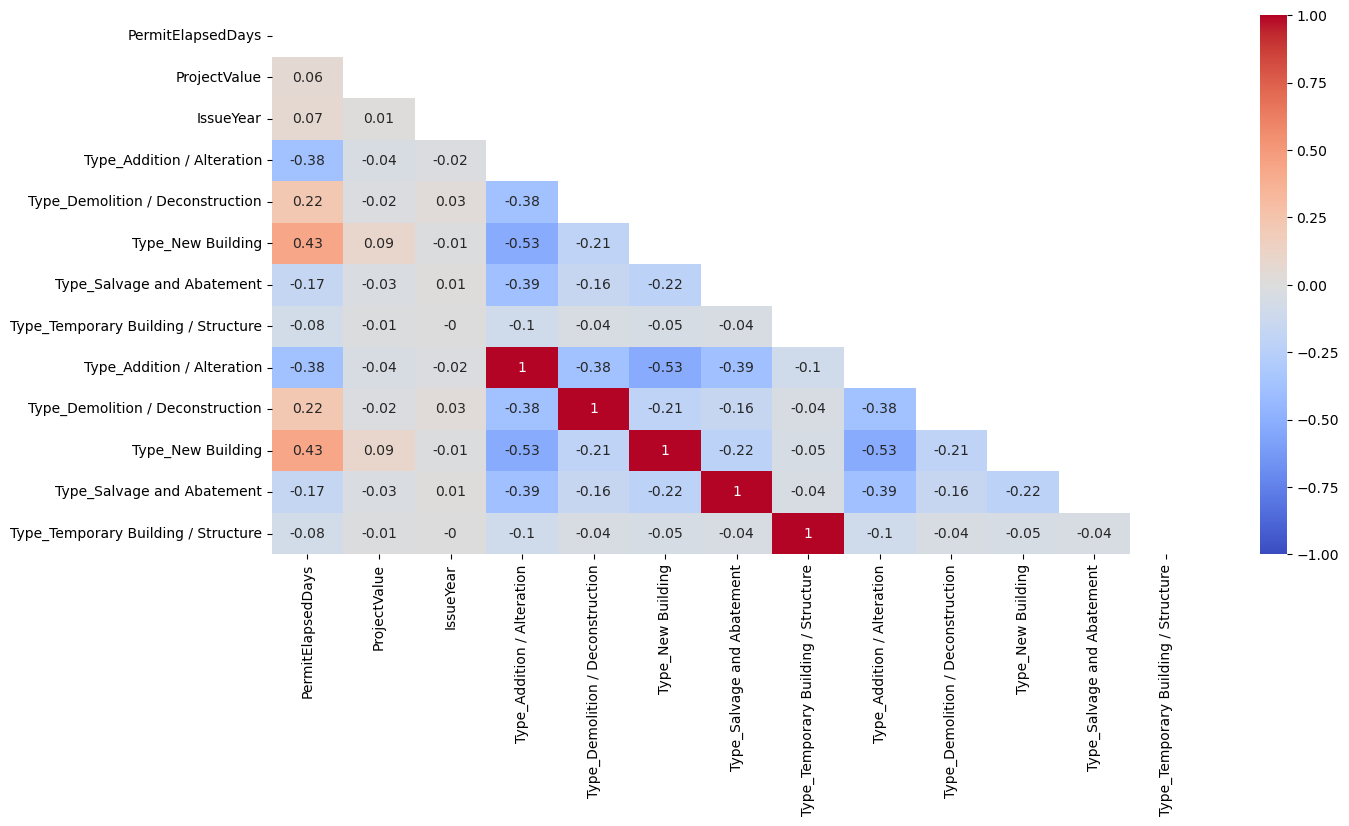

In [194]:
# Heatmap 3.0
plt.figure(figsize=(15,7))

# creating mask of duplicated combinations
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

sns.heatmap(corr_mat, mask=mask, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=True)

plt.show()

## Visualisation and Data Analysis


### _Part 2. 1. Using an appropriate visual, or visuals, explore the relationship between mosquito number and date._

Let's plot how the Mosquito number is changing during the date and time. But first, it can be useful for aggregating and summarizing data in a more compact form, especially when dealing with time-series data grouped by various dimensions. From the details about the data set, we know that: These test results are organized in such a way that when the number of mosquitoes exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitoes are capped at 50.

In [56]:
aggregated_df = mosquito_df.groupby(['Year', 'Week', 'Address Block', 'Trap', 'Trap type', 'Date','Mosquito ID', 'WNV Present', 'Species', 'Lat','Lon'])['Mosquito number'].sum().reset_index()


In [57]:
aggregated_df.set_index('Date', inplace=True)
print(aggregated_df.index)

DatetimeIndex(['2007-05-29 00:05:00', '2007-05-29 00:05:00',
               '2007-05-29 00:05:00', '2007-05-29 00:05:00',
               '2007-05-29 00:05:00', '2007-05-29 00:05:00',
               '2007-05-29 00:05:00', '2007-05-29 00:05:00',
               '2007-05-29 00:05:00', '2007-05-29 00:05:00',
               ...
               '2019-09-26 00:09:00', '2019-09-26 00:09:00',
               '2019-09-26 00:09:00', '2019-09-26 00:09:00',
               '2019-09-26 00:09:00', '2019-09-26 00:09:00',
               '2019-09-26 00:09:00', '2019-09-26 00:09:00',
               '2019-09-26 00:09:00', '2019-09-26 00:09:00'],
              dtype='datetime64[ns]', name='Date', length=17391, freq=None)


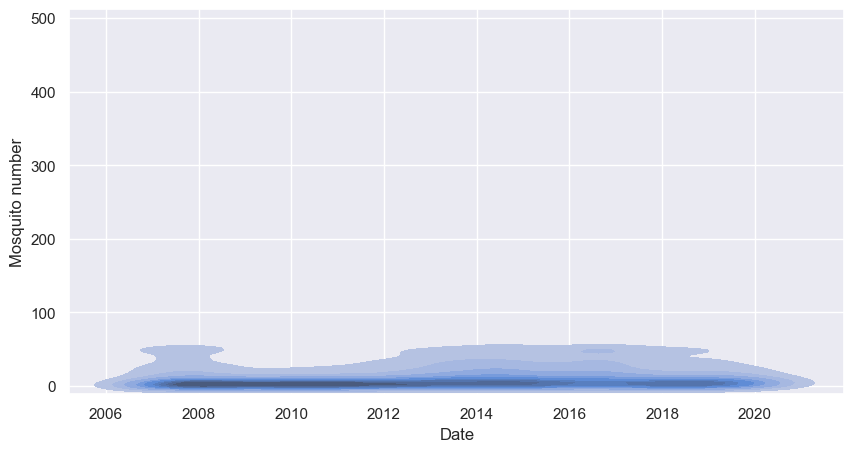

In [58]:
plt.figure(figsize=(10, 5))
sns.kdeplot(x=aggregated_df.index, y=aggregated_df['Mosquito number'], fill=True, thresh=0.05)
plt.xlabel('Date')
plt.ylabel('Mosquito number')
plt.show()

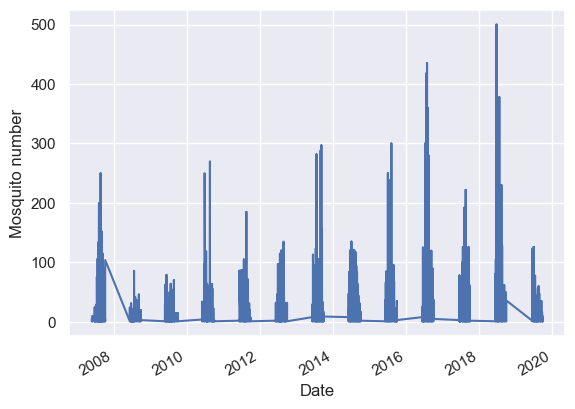

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

aggregated_df["Mosquito number"].plot();
plt.ylabel('Mosquito number');

As we can see above, there is the yearly pattern. Let's investigate further by resampling by  and month:


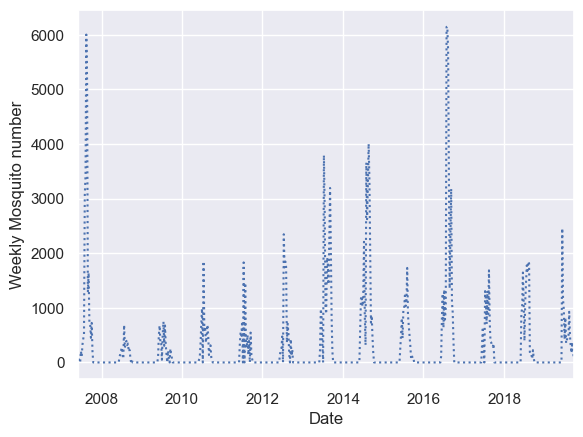

In [482]:
weekly = aggregated_df["Mosquito number"].resample('W').sum()
weekly.plot(style=[':', '--', '-'])
plt.ylabel('Weekly Mosquito number');


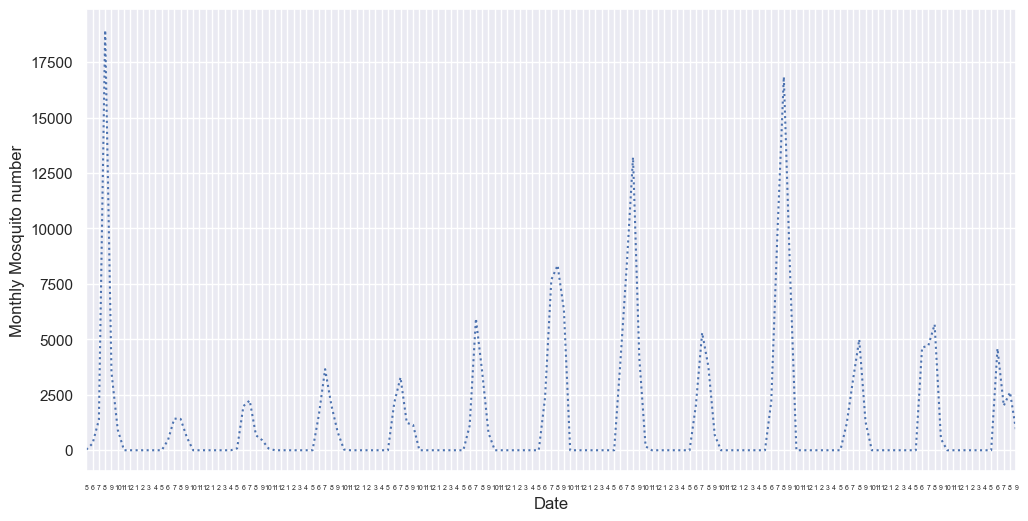

In [60]:
monthly = aggregated_df["Mosquito number"].resample('M').sum()
plt.figure(figsize=(12, 6))
monthly.plot(style=[':', '--', '-'])
plt.xticks(monthly.index, monthly.index.month, rotation=0, ha='center', fontsize=5)

plt.ylabel('Monthly Mosquito number');


The above plots reveal that the number of mosquito grows every year around summer (May - November). 
However, the details of the data set contains this note: Please note that not all the locations are tested at 
    all times. Also, records exist only when a particular species of mosquitoes is found at a certain trap at 
    a certain time.
 Thus, it is hard to say if it is a pattern or they just gathered information only for those months.

Let's take a loot into each year:

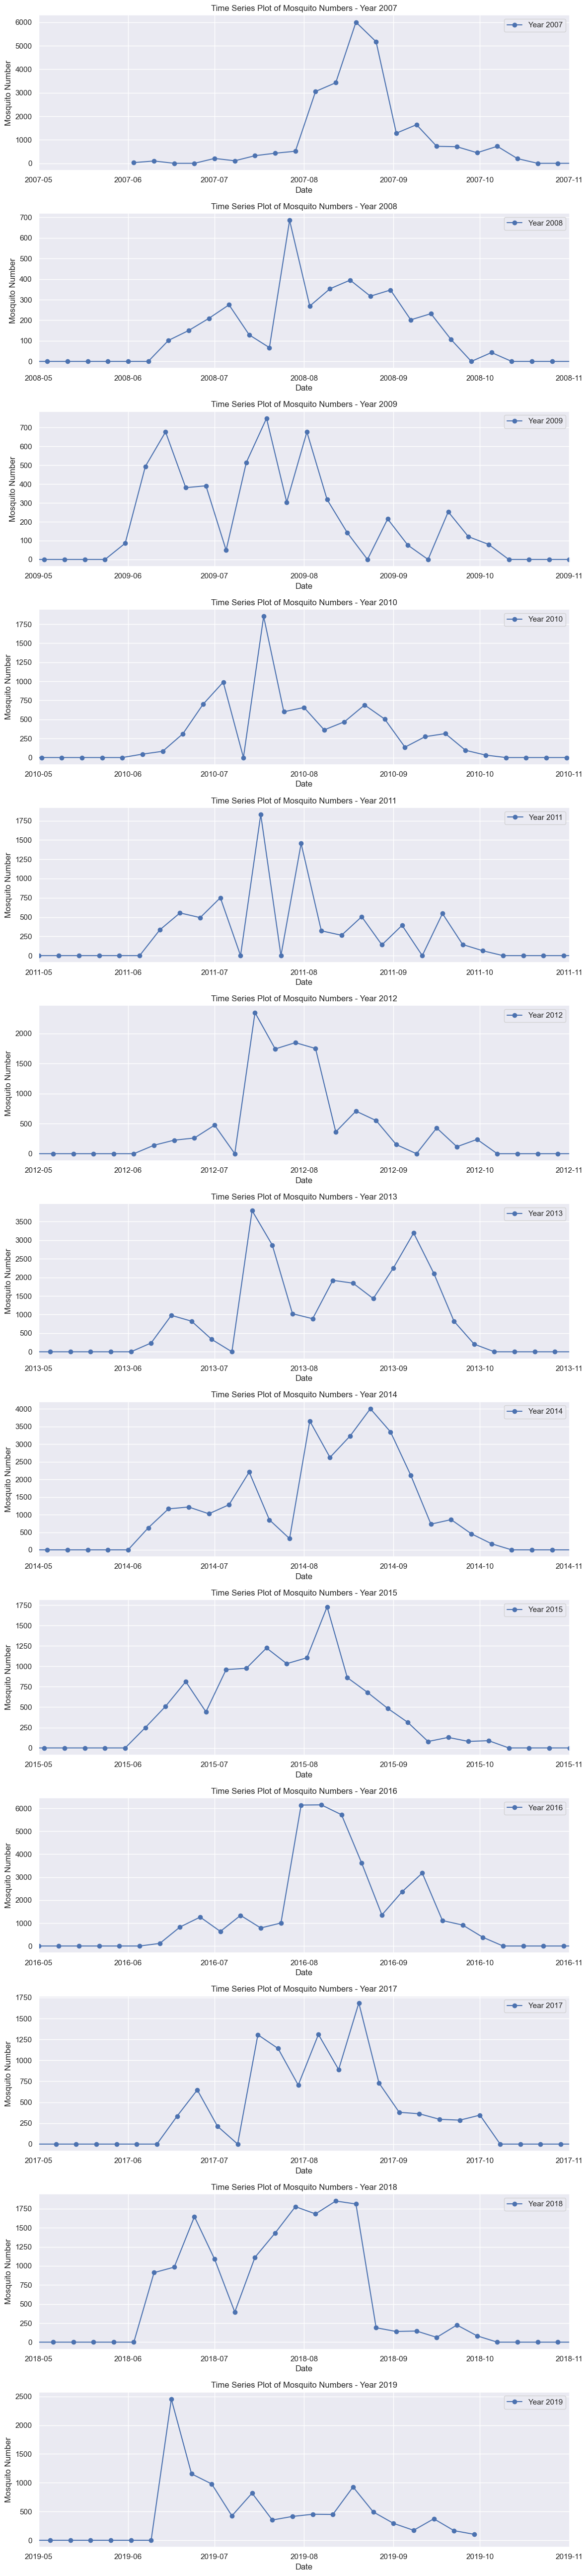

In [61]:
    weekly = aggregated_df.resample('W').sum()
   
    # Create subplots for each year
    fig, axes = plt.subplots(nrows=len(weekly.index.year.unique()), figsize=(12, 4 * len(weekly.index.year.unique())))

    # Plot each year separately
    for ax, (year, data) in zip(axes, weekly.groupby(weekly.index.year)):
        ax.plot(data.index, data['Mosquito number'], marker='o', linestyle='-', label=f'Year {year}')
        ax.set_title(f'Time Series Plot of Mosquito Numbers - Year {year}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Mosquito Number')
        ax.grid(True)
        ax.legend()

        # Set x-axis limits to cover the range of months for each year
        ax.set_xlim(pd.Timestamp(f'{year}-05-01'), pd.Timestamp(f'{year}-11-01'))

    plt.tight_layout()
    plt.show()

### Insights:
The number of mosquito grows every year around summer (May - November).

Despate the fact that the each year has the different number of mosquito for different months, there is a pattern that, around August, the number of mosquitos is one of the highest.

2016 year had the unusually huge number of the mosquitos.

### _Part 3 - Advanced EDA 1. Using an appropriate visual, explore the relationship between mosquito species and WNV prevalence._

#### Univariate Visualizations
Let's first analyse those variables separatly.

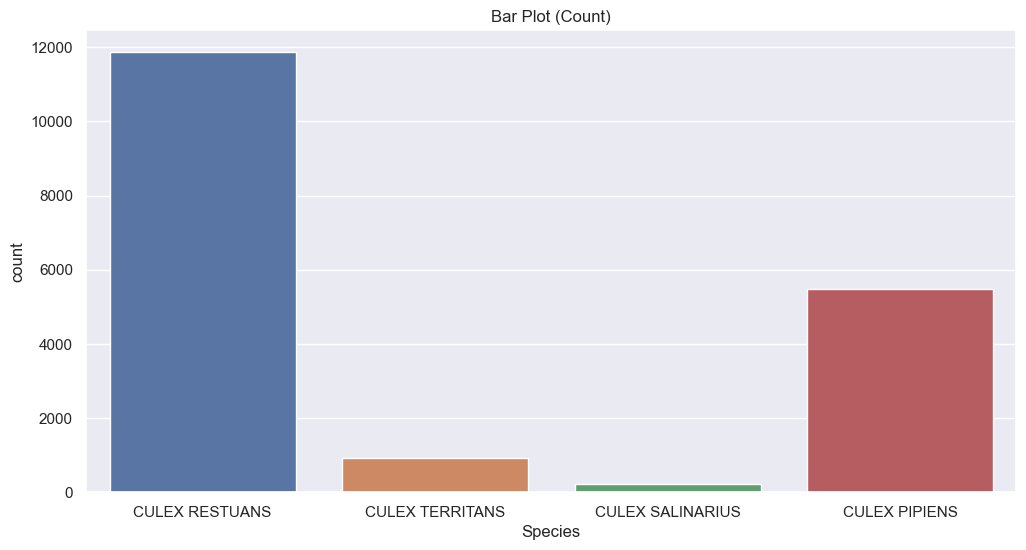

In [62]:

plt.figure(figsize=(12, 6))
sns.countplot(x=mosquito_df['Species'])
plt.title("Bar Plot (Count)")
plt.show()


In [63]:
species_statistics = mosquito_df.groupby('Species')['Mosquito number'].describe()

# Print the statistics
print(species_statistics)

                    count       mean        std  min  25%  50%   75%   max
Species                                                                   
CULEX PIPIENS      5486.0  11.185563  13.693913  1.0  2.0  5.0  15.0  50.0
CULEX RESTUANS    11866.0  11.594977  13.673360  1.0  2.0  5.0  16.0  50.0
CULEX SALINARIUS    226.0   2.053097   3.853635  1.0  1.0  1.0   2.0  48.0
CULEX TERRITANS     917.0   1.973828   3.461165  1.0  1.0  1.0   2.0  46.0


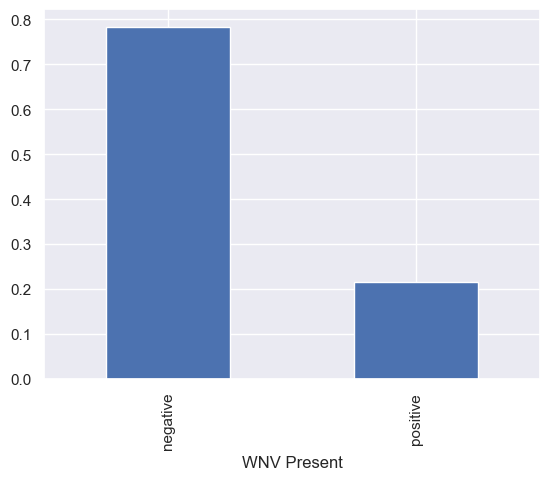

In [269]:


mosquito_df['WNV Present'].value_counts(normalize=True).plot(kind="bar")
plt.show()

A relevant insights that these graphs reveal are:

    Culex restuans (11866) species is the most common one and culex salinarus (226) is the rare one.

    There is a approximently 80-20 split between the mosquitos with negative/positive WNV.
    

#### Multivariate visualizations

Lets see if certain Species are more likely to have positive WNV:

In [64]:
mosquito_df.groupby(["Species", "WNV Present"])["WNV Present"].count() / mosquito_df.groupby("Species")["WNV Present"].count()

Species           WNV Present
CULEX PIPIENS     negative       0.742618
                  positive       0.257382
CULEX RESTUANS    negative       0.784510
                  positive       0.215490
CULEX SALINARIUS  negative       0.951327
                  positive       0.048673
CULEX TERRITANS   negative       0.984733
                  positive       0.015267
Name: WNV Present, dtype: float64

Looking at this, the Culex pipiens and Culex Restuans stands out, 
much higher positive rates for these groups, 26% and 21% respectively. 


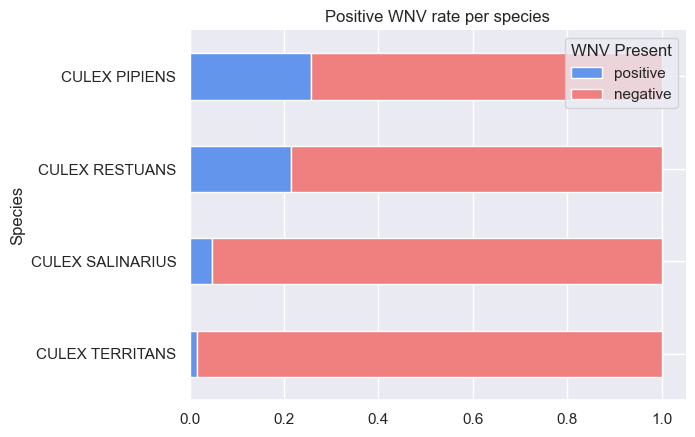

In [65]:
rate_data = mosquito_df.groupby(["Species", "WNV Present"])["WNV Present"].count() / mosquito_df.groupby("Species")["WNV Present"].count()

rate_data.unstack()[["positive", "negative"]].sort_values("positive").plot(kind="barh", stacked=True, color=["cornflowerblue", "lightcoral"])
plt.title("Positive WNV rate per species")
sns.despine()
plt.show()

### Insights:
There are 4 species.Culex restuans (11866) species is the most common one and culex salinarus (226) is the rare one.

There is a approximently 80-20 split between the mosquitos with negative/positive WNV.

The Culex pipiens and Culex Restuans has the higher positive rates for these groups, 26% and 21% respectively. However the Hypothesis Test should be performed to check if there is a statistically significant difference between the different mosquito species when looking at the occurrence of West Nile Virus. 


### _Part 3. 2. Using an appropriate visual, explore the relationship between the number of mosquitos caught and trap type._

#### Univariate Visualizations
Let's first analyse those variables separatly.

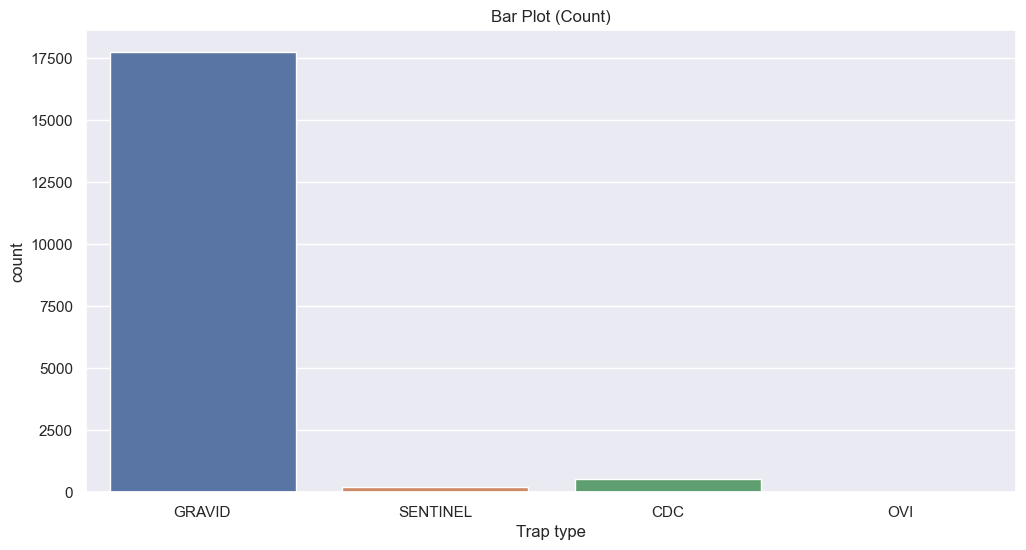

In [66]:
plt.figure(figsize=(12, 6))
sns.countplot(x=mosquito_df['Trap type'])
plt.title("Bar Plot (Count)")
plt.show()

In [67]:
type_statistics = mosquito_df.groupby('Trap type')['Mosquito number'].describe()

# Print the statistics
print(type_statistics)

             count       mean        std  min  25%   50%   75%   max
Trap type                                                           
CDC          544.0  18.167279  19.221678  1.0  2.0   7.0  37.0  50.0
GRAVID     17741.0  10.495801  13.041122  1.0  2.0   5.0  14.0  50.0
OVI            1.0   1.000000        NaN  1.0  1.0   1.0   1.0   1.0
SENTINEL     209.0  24.564593  18.301347  1.0  7.0  20.0  45.0  50.0


GRAVID is significatly dominating among all trap type.

#### Multivariate visualizations
Let's see what relationship the Trap type and Mosquito number have:

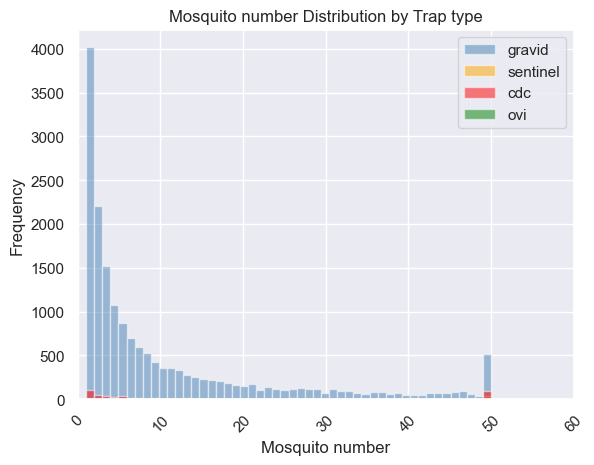

In [68]:

gravid = mosquito_df[mosquito_df['Trap type'] == 'GRAVID']
sentinel = mosquito_df[mosquito_df['Trap type'] == 'SENTINEL']
cdc = mosquito_df[mosquito_df['Trap type'] == 'CDC']
ovi = mosquito_df[mosquito_df['Trap type'] == 'OVI']

# We can plot two histograms on the same figure

plt.hist(gravid['Mosquito number'], label='gravid', color="steelblue", alpha=0.5, bins=50)
plt.hist(sentinel['Mosquito number'], label='sentinel', color="orange", alpha=0.5, bins=50)
plt.hist(cdc['Mosquito number'], label='cdc', color="red", alpha=0.5, bins=50)
plt.hist(ovi['Mosquito number'], label='ovi', color="green", alpha=0.5, bins=50)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.xlabel('Mosquito number')
plt.ylabel('Frequency')
plt.title('Mosquito number Distribution by Trap type')
x_range = (0, 60)
plt.xlim(x_range)
plt.legend()
plt.show()


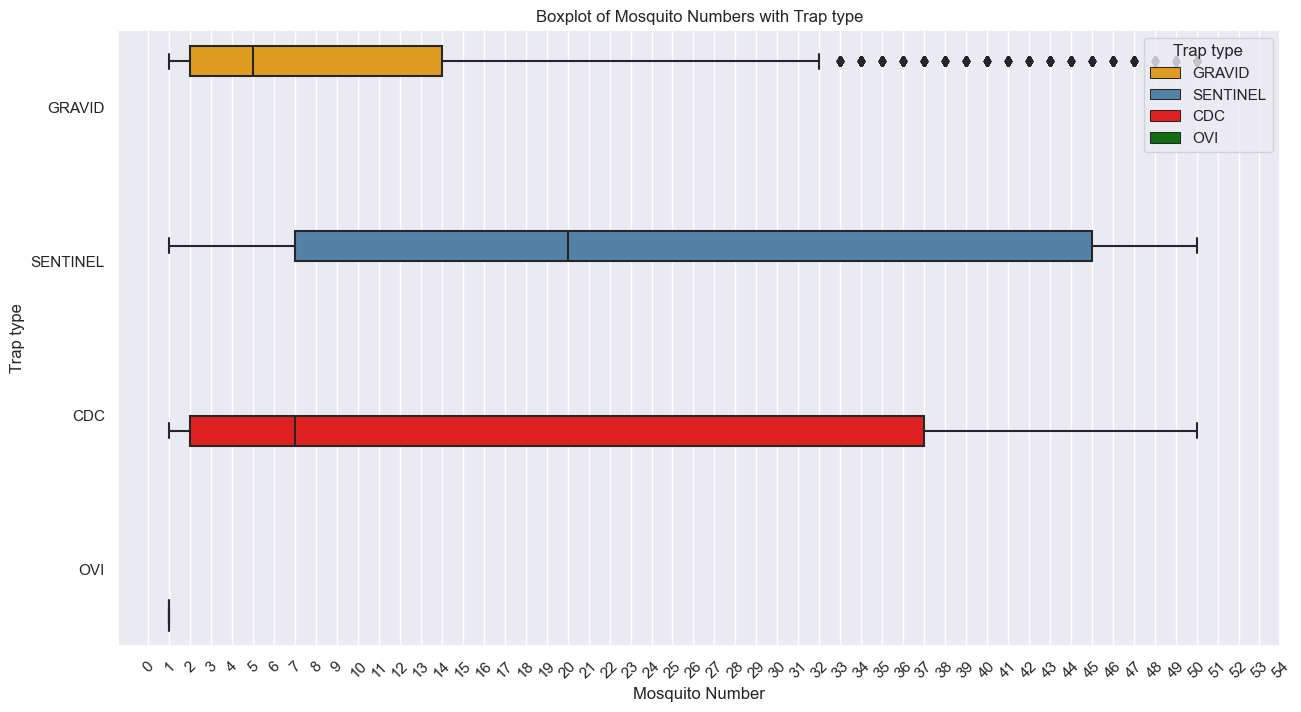

In [545]:
plt.figure(figsize=(15, 8))
ax = sns.boxplot(x=mosquito_df['Mosquito number'], y=mosquito_df['Trap type'], hue=mosquito_df['Trap type'], palette=["orange", "steelblue", "red","green"])
plt.xticks(rotation=45)
ax.set_xticks(range(0, 55, 1))

plt.legend(title='Trap type', loc='upper right')
plt.xlabel('Mosquito Number')
plt.ylabel('Trap type')
plt.title('Boxplot of Mosquito Numbers with Trap type')

plt.show()


#### Insights:
   GRAVID is significatly dominating among all trap type with total number of count as 17741. CDC- 544.0   and 
SENTINEL - 209.0.
   
   OVI type has just 1 record.
   
   GRAVID has the average number of mosquitoes as 5 and range from 2 - 14.
   
   CDC has the broader range from 2 to 37 and average 7.
   
   SENTINEL has 20 mosquitos in the average with range 7 to 45.
   
   It seems that SENTINEL catches more mosquitos However, the Hypothesis Test should be performed further to confirm it.
    

### _Part 3 - Advanced EDA. 3. Using an appropriate visual, come up with an additional insight of your choice._


I would like to investigate the Times Series further and see the mosquitos with positive West Nile Virus as overall trend and per year.

In [69]:
aggregated_df = mosquito_df.groupby(['Year', 'Week', 'Address Block', 'Trap', 'Trap type', 'Date','Mosquito ID', 'WNV Present', 'Species', 'Lat','Lon'])['Mosquito number'].sum().reset_index()
aggregated_df.set_index('Date', inplace=True)
print(aggregated_df.index)

DatetimeIndex(['2007-05-29 00:05:00', '2007-05-29 00:05:00',
               '2007-05-29 00:05:00', '2007-05-29 00:05:00',
               '2007-05-29 00:05:00', '2007-05-29 00:05:00',
               '2007-05-29 00:05:00', '2007-05-29 00:05:00',
               '2007-05-29 00:05:00', '2007-05-29 00:05:00',
               ...
               '2019-09-26 00:09:00', '2019-09-26 00:09:00',
               '2019-09-26 00:09:00', '2019-09-26 00:09:00',
               '2019-09-26 00:09:00', '2019-09-26 00:09:00',
               '2019-09-26 00:09:00', '2019-09-26 00:09:00',
               '2019-09-26 00:09:00', '2019-09-26 00:09:00'],
              dtype='datetime64[ns]', name='Date', length=17391, freq=None)


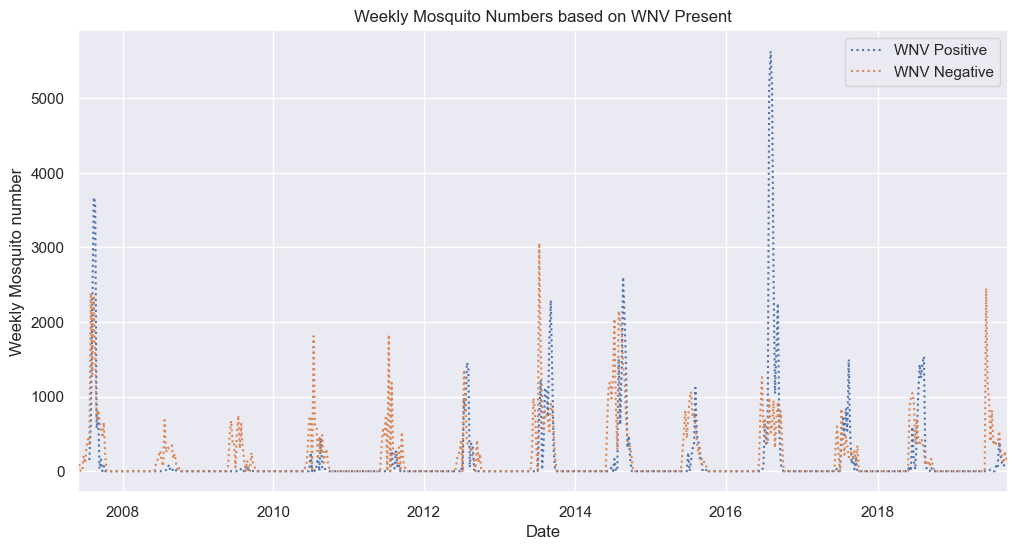

In [70]:
positive_weekly = aggregated_df[aggregated_df['WNV Present'] == 'positive']["Mosquito number"].resample('W').sum()
negative_weekly = aggregated_df[aggregated_df['WNV Present'] == 'negative']["Mosquito number"].resample('W').sum()

# Plot the data
plt.figure(figsize=(12, 6))

# Plot for positive cases
positive_weekly.plot(style=[':', '--', '-'], label='WNV Positive')

# Plot for negative cases
negative_weekly.plot(style=[':', '--', '-'], label='WNV Negative')

# Add labels and title
plt.ylabel('Weekly Mosquito number')
plt.legend()
plt.title('Weekly Mosquito Numbers based on WNV Present')

plt.show()

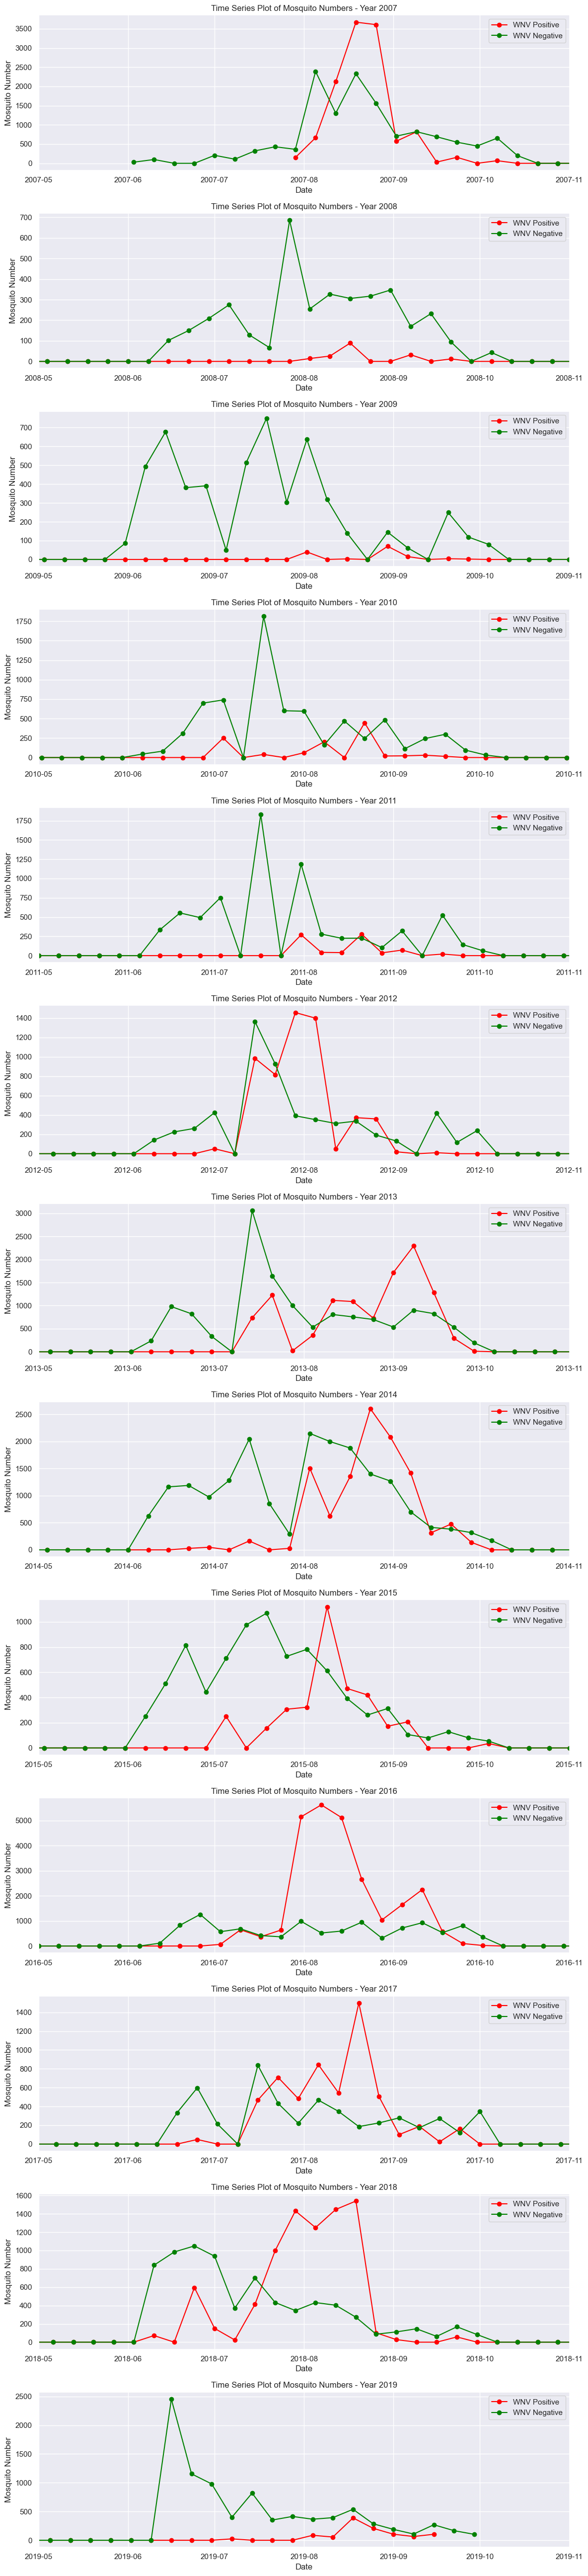

In [71]:
positive_weekly = aggregated_df[aggregated_df['WNV Present'] == 'positive']["Mosquito number"].resample('W').sum()
negative_weekly = aggregated_df[aggregated_df['WNV Present'] == 'negative']["Mosquito number"].resample('W').sum()

# Create subplots for each year
years = sorted(aggregated_df.index.year.unique())
fig, axes = plt.subplots(nrows=len(years), figsize=(12, 4 * len(years)))

# Plot each year separately
for ax, year in zip(axes, years):
    # Plot positive values
    positive_data = positive_weekly[positive_weekly.index.year == year]
    ax.plot(positive_data.index, positive_data, marker='o', linestyle='-', label=f'WNV Positive', color='red')

    # Plot negative values
    negative_data = negative_weekly[negative_weekly.index.year == year]
    ax.plot(negative_data.index, negative_data, marker='o', linestyle='-', label=f'WNV Negative', color='green')

    ax.set_title(f'Time Series Plot of Mosquito Numbers - Year {year}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mosquito Number')
    ax.grid(True)
    ax.legend()

    # Set x-axis limits to cover the range of weeks for each year
    ax.set_xlim(pd.Timestamp(f'{year}-05-01'), pd.Timestamp(f'{year}-11-01'))

plt.tight_layout()
plt.show()


#### Insights:
There is a pattern that the mosquitoes with positive MNV are around August and September. However the Hypothesis Test should be performed further.

August of 2016 year had the unusually huge number of the mosquitos with positive MNV.
    

### Conclusion
Based on the initial analysis, let's summarize the key findings regarding the distinctions between mosquitoes with positive and negative West Nile Virus (WNV) in the dataset.

It was observed that the overall mosquito population experiences growth annually, particularly during the summer months (May to November). Notably, mosquitoes with positive WNV are predominantly present in August and September.

There is an approximate 80-20 split between mosquitoes with negative and positive WNV.

The Culex restuans species stands out as the most common mosquito species, exhibiting the highest positive WNV rates at 21%. This makes it the most dangerous species among others.

In terms of trap types, the GRAVID trap is the most commonly used; however, the SENTINEL trap captures a higher number of mosquitoes. 

Further investigation is required to validate those hypothesis and Hypothesis Tests should be performed.



<br>

<div id="container" style="position:relative;">
<div style="position:relative; float:right">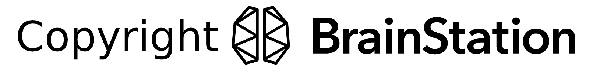
</div>
</div>
